In [1]:
import matplotlib.pyplot as plt

"""
Small demo to illustrate how the plot function and the gridworld environment work
"""
import numpy as np
import optuna
from gridworld import *
from plot import *
import optimize
import select_action
from sarsa import *
from qlearning import *
#from optimize import *

COUNT_ENVIRONMENT = 10

In [2]:
SARSA_PARAMS_A1 = optimize.load_study('DRL_Studienarbeit1_A1_sarsa','sqlite:///DRL_Studienarbeit1_A1_sarsa.db')
SARSA_PARAMS_A2 = optimize.load_study('DRL_Studienarbeit1_A2_sarsa','sqlite:///DRL_Studienarbeit1_A2_sarsa.db')

Q_PARAMS_A1 = optimize.load_study('DRL_Studienarbeit1_A1','sqlite:///DRL_Studienarbeit1_A1.db')
Q_PARAMS_A2 = optimize.load_study('test','sqlite:///DRL_Studienarbeit1_A2.db')


In [3]:
#study = optimize(env)
#study.run_study_qlearning_steps("test", "sqlite:///test.db", "maximize")


# Plot 1: Cumulative reward of the current episode over episodes

In [3]:
qlearning_data={}
sarsa_data={}
qlearning_data_no_decay={}
sarsa_data_no_decay={}
envs_A1 = []

q = qlearning(Q_PARAMS_A1['ALPHA'],
                  Q_PARAMS_A1['GAMMA'],
                  Q_PARAMS_A1['EPISODES'],
                  Q_PARAMS_A1['MAX_EPISODE_LENGTH'],
                  Q_PARAMS_A1['INIT_REWARD'],
                  Q_PARAMS_A1['EPS'],
                  Q_PARAMS_A1['DECAY'])

q_no_decay = qlearning(Q_PARAMS_A1['ALPHA'],
                  Q_PARAMS_A1['GAMMA'],
                  Q_PARAMS_A1['EPISODES'],
                  Q_PARAMS_A1['MAX_EPISODE_LENGTH'],
                  Q_PARAMS_A1['INIT_REWARD'],
                  Q_PARAMS_A1['EPS'])

s = sarsa(SARSA_PARAMS_A1['ALPHA'],
          SARSA_PARAMS_A1['GAMMA'],
          SARSA_PARAMS_A1['EPISODES'],
          SARSA_PARAMS_A1['MAX_EPISODE_LENGTH'],
          SARSA_PARAMS_A1['INIT_REWARD'],
          SARSA_PARAMS_A1['EPS'],
          SARSA_PARAMS_A1['DECAY'])

s_no_decay = sarsa(SARSA_PARAMS_A1['ALPHA'],
          SARSA_PARAMS_A1['GAMMA'],
          SARSA_PARAMS_A1['EPISODES'],
          SARSA_PARAMS_A1['MAX_EPISODE_LENGTH'],
          SARSA_PARAMS_A1['INIT_REWARD'],
          SARSA_PARAMS_A1['EPS'])


for i in range(COUNT_ENVIRONMENT):
    env = Random(size=12, water=0.3, mountain=0)
    envs_A1.append(env)     
    print(f"running environment: {i}")
    
    qlearning_data[i] = q.run_decay_epsilon_greedy(env)
    sarsa_data[i] = s.run_decay_epsilon_greedy(env)
    
    qlearning_data_no_decay[i] = q_no_decay.run_epsilon_greedy(env)
    sarsa_data_no_decay[i] = s_no_decay.run_epsilon_greedy(env)

running environment: 0
running environment: 1
running environment: 2
running environment: 3
running environment: 4
running environment: 5
running environment: 6
running environment: 7
running environment: 8
running environment: 9


## Decaying Epsilon Greedy

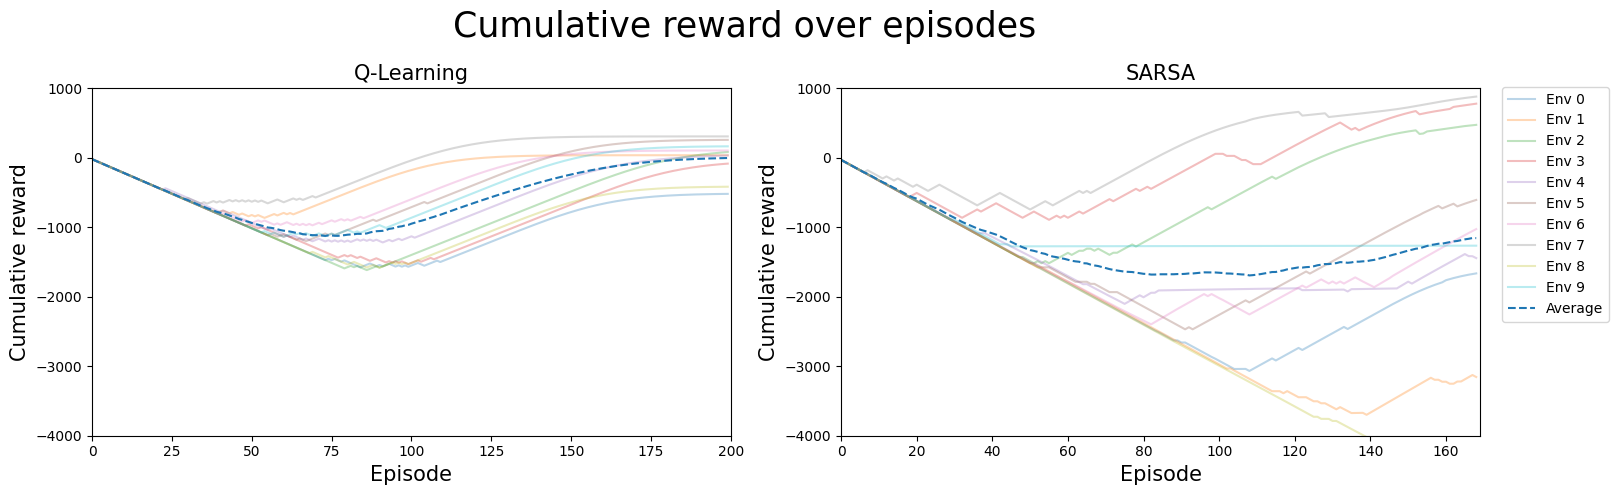

In [4]:
plot_episodes([qlearning_data, sarsa_data], [Q_PARAMS_A1['EPISODES'], SARSA_PARAMS_A1['EPISODES']], ['Q-Learning', 'SARSA'])

## Epsilon Greedy

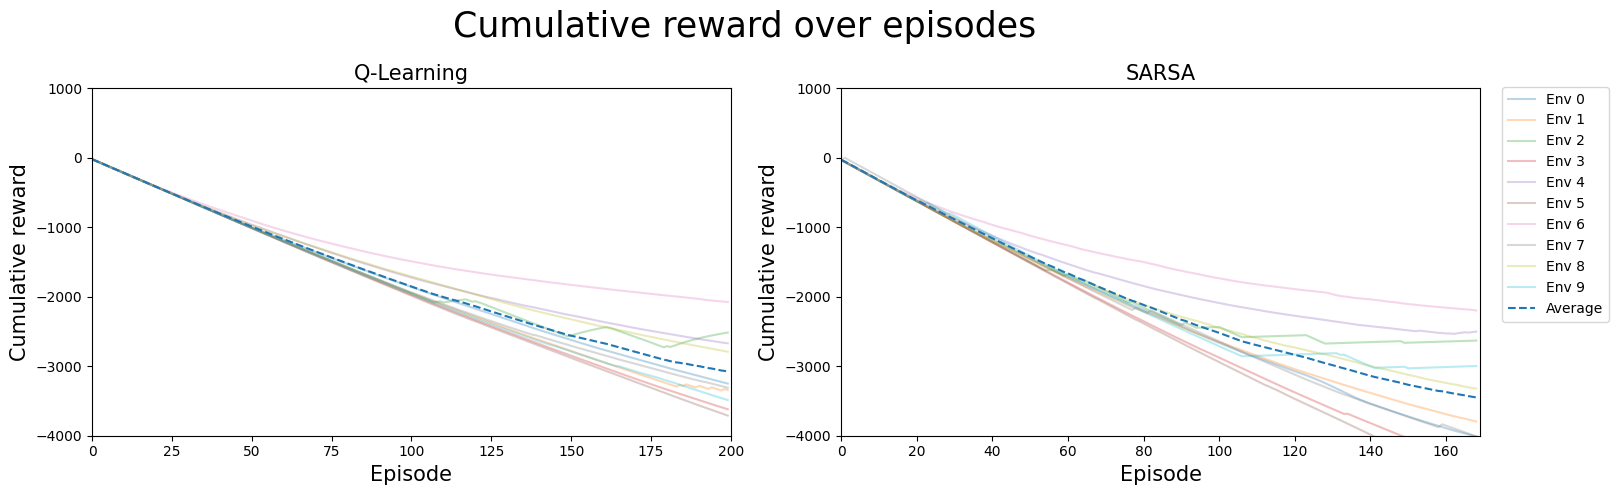

In [5]:
plot_episodes([qlearning_data_no_decay, sarsa_data_no_decay], [Q_PARAMS_A1['EPISODES'], SARSA_PARAMS_A1['EPISODES']], ['Q-Learning', 'SARSA'])

# Plot 2: Cumulative reward over amount of steps

In [7]:
qlearning_data_A2={}
sarsa_data_A2={}
qlearning_data_no_decay_A2={}
sarsa_data_no_decay_A2={}
envs2 = []

q2 = qlearning(Q_PARAMS_A2['ALPHA'],
                Q_PARAMS_A2['GAMMA'],
                Q_PARAMS_A2['EPISODES'],
                Q_PARAMS_A2['MAX_EPISODE_LENGTH'],
                Q_PARAMS_A2['INIT_VALUE'],
                Q_PARAMS_A2['EPS'],
                Q_PARAMS_A2['DECAY'])

s2 = sarsa(SARSA_PARAMS_A2['ALPHA'],
            SARSA_PARAMS_A2['GAMMA'],
            SARSA_PARAMS_A2['EPISODES'],
            SARSA_PARAMS_A2['MAX_EPISODE_LENGTH'],
            SARSA_PARAMS_A2['INIT_REWARD'],
            SARSA_PARAMS_A2['EPS'],
            SARSA_PARAMS_A2['DECAY'])

s_no_decay_2 = sarsa(SARSA_PARAMS_A1['ALPHA'],
          SARSA_PARAMS_A1['GAMMA'],
          SARSA_PARAMS_A1['EPISODES'],
          SARSA_PARAMS_A1['MAX_EPISODE_LENGTH'],
          SARSA_PARAMS_A1['INIT_REWARD'],
          SARSA_PARAMS_A1['EPS'])

q_no_decay_2 = qlearning(Q_PARAMS_A1['ALPHA'],
                  Q_PARAMS_A1['GAMMA'],
                  Q_PARAMS_A1['EPISODES'],
                  Q_PARAMS_A1['MAX_EPISODE_LENGTH'],
                  Q_PARAMS_A1['INIT_REWARD'],
                  Q_PARAMS_A1['EPS'])

for i in range(COUNT_ENVIRONMENT):
    env = Random(size=12, water=0, mountain=0.3)
    envs2.append(env)
    print(f"running env: {i}")
    
    qlearning_data_A2[i] = q2.run_decay_epsilon_greedy(env)
    sarsa_data_A2[i] = s2.run_decay_epsilon_greedy(env)
    
    qlearning_data_no_decay[i] = q_no_decay_2.run_epsilon_greedy(env)
    sarsa_data_no_decay[i] = s_no_decay_2.run_epsilon_greedy(env)


running env: 0
running env: 1
running env: 2
running env: 3
running env: 4
running env: 5
running env: 6
running env: 7
running env: 8
running env: 9


# Decaying Epsilon Greedy

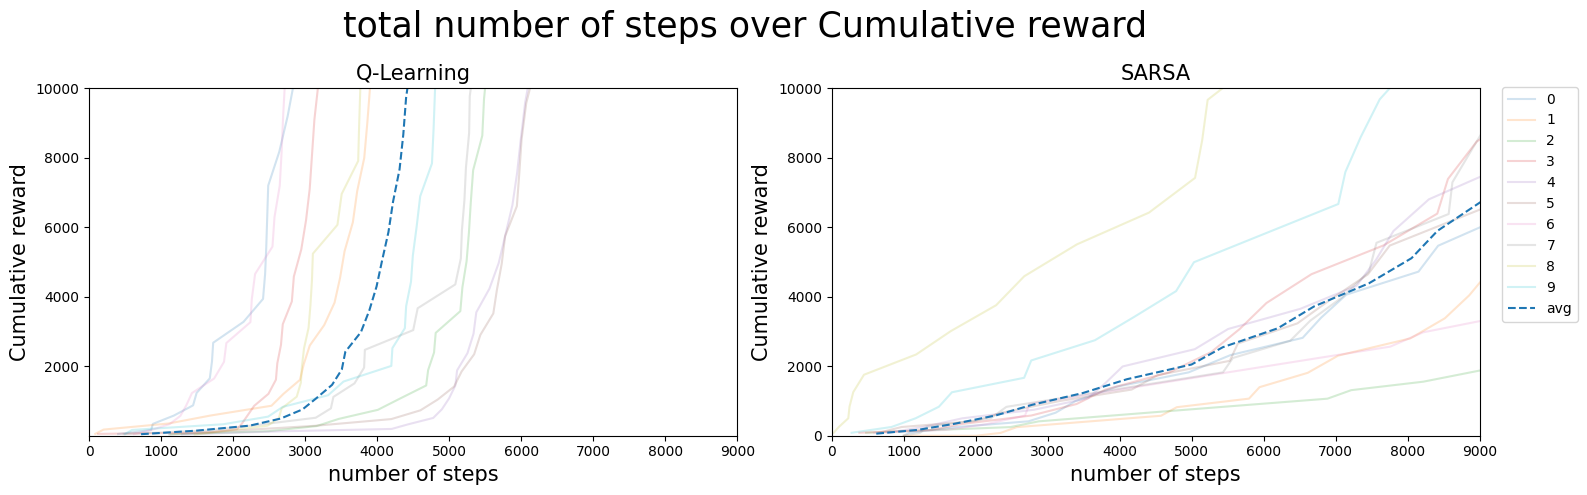

In [8]:
plot_steps([qlearning_data_A2, sarsa_data_A2], [Q_PARAMS_A2['EPISODES'], SARSA_PARAMS_A2['EPISODES']], ['Q-Learning', 'SARSA'])

# Epsilon Greedy

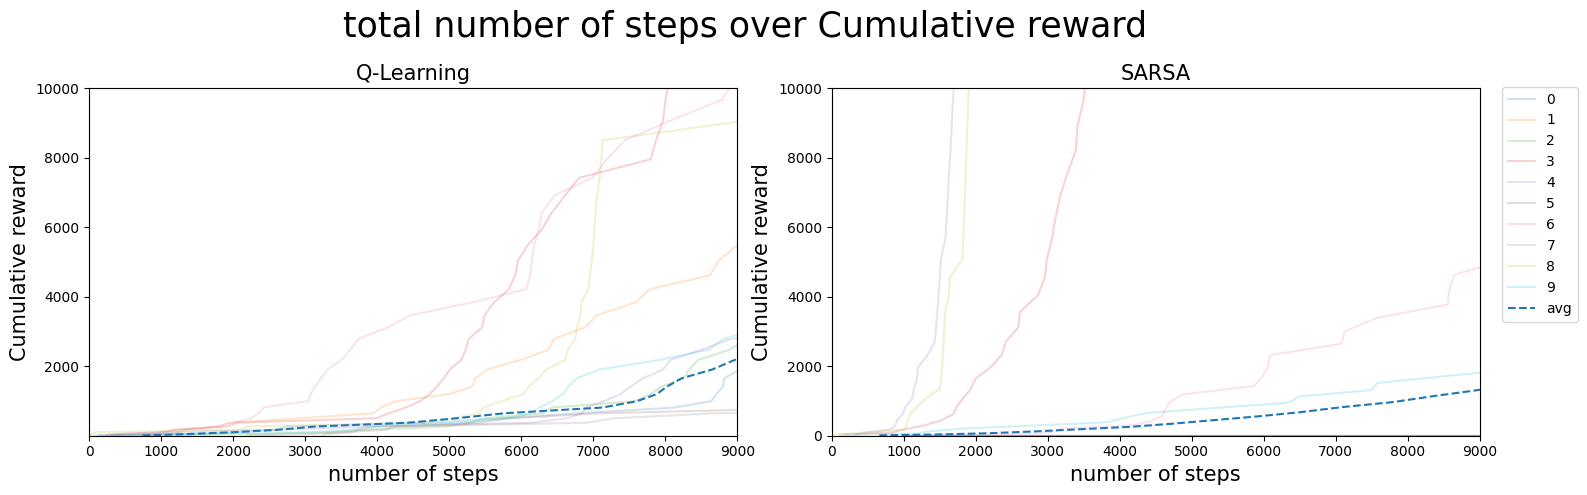

In [9]:
plot_steps([qlearning_data_no_decay, sarsa_data_no_decay], [Q_PARAMS_A2['EPISODES'], SARSA_PARAMS_A2['EPISODES']], ['Q-Learning', 'SARSA'])
